## 金融风控项目
在此项目中，需要完成金融风控模型的搭建。 基于一个用户的基本信息、历史信息来预测逾期与否。采样的具体数据是拍拍贷数据。https://www.kesci.com/home/competition/56cd5f02b89b5bd026cb39c9/content/1
在此数据中提供了三种不同类型的数据:
1. Master: 用户的主要信息
2. Loginfo: 登录信息
3. Userupdateinfo: 修改信息

在本次项目中，我们只使用```Master```的信息来预测一个用户是否会逾期。 数据里有一个字段叫作```Target```是样本的标签（label)。 在```Master```表格里，包含200多个特征，但不少特征具有缺失值。 做项目的时候需要仔细处理一下。 

```数据```
- ```Training/PPD_Training_Master_GBK_3_1_Training_Set.csv```:  训练数据
- ```Test/PPD_Master_GBK_2_Test_Set.csv```: 测试数据

In [1]:
import numpy as np 
import math 
import pandas as pd 
pd.set_option('display.float_format',lambda x:'%.3f' % x)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns 
sns.set_palette('muted')
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import os 

In [2]:
# 取消显示所有行列的最大限制
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# 在jupyter notebook中显示中文
plt.rcParams['font.sans-serif']=['SimHei']# 设置加载的字体名
plt.rcParams['axes.unicode_minus']=False #解决保存图像是负号'-'显示为方块的问题

In [3]:
# 读取Master数据
data = pd.read_csv('data/Training/PPD_Training_Master_GBK_3_1_Training_Set.csv',encoding='gb18030')

In [9]:
# 正负样本的比例， 可以看出样本比例不平衡的
data.target.value_counts()

0    27802
1     2198
Name: target, dtype: int64

> #### 1. 数据的预处。 需要考虑以下几个方面：
- ```缺失值```。数据里有大量的缺失值，需要做一些处理。 
- ```字符串的清洗```。比如“北京市”和“北京”合并成“北京”， 统一转换成小写等
- ```二值化```。具体方法请参考课程里的介绍
- ```衍生特征```：比如户籍地和当前城市是否是同一个？ 
- ```特征的独热编码```：对于类别型特征使用独热编码形式
- ```连续性特征的处理```：根据情况来处理
- ```其他```: 根据情况，自行决定要不要做

## 一、数据清洗

In [4]:
# 原始数据为-1的表示为缺失
data = data.replace({-1:np.nan})

In [9]:
# 该函数对缺失60%以上的特征和样本进行删除处理，但有更简单高效的方法在下一个代码栏里
def del_upSix_featureSample(data):
    '''
    parameters
    ----------
    data: dataFrame格式的数据集
    '''
    # 获取缺失60%以上的特征名和样本id
    featrue_missing_lsit = list(data.columns[data.isnull().sum()>30000*0.6])
    sample_missing_list = []
    for i in range(len(data)):
        if data.iloc[i,:].isnull().sum() > data.shape[1]*0.6:
            sample_missing_list.append(i)
    # 进行删除
    for col in featrue_missing_lsit:
        data.drop(columns=[col], inplace=True, axis=1)
    for raw in sample_missing_list:
        data.drop(data.index[raw], inplace=True)
    # 返回data
    return data

**对缺失值进行删除**

In [5]:
print("删除缺失值之前的shape：{}".format(data.shape))
# 删除缺失值大于228*0.6=136的单个样本（行）
data = data.dropna(thresh=136)
# 删除缺失值大于30000*0.6=18000的特征（列）
data = data.dropna(thresh=18000, axis=1)
print("删除缺失值之后的shape：{}".format(data.shape))

删除缺失值之前的shape：(30000, 228)
删除缺失值之后的shape：(29435, 196)


**删除地名中包含的“市”**

In [6]:
# 对UserInfo_8进行处理
data['UserInfo_8'] = [s[:-1] if s.find("市")>0 else s[:] for s in data.UserInfo_8]
data['UserInfo_20'] = [x[:-1] if x.find('市')>0 else x[:] for x in data['UserInfo_20']]

**缺失值填充**

In [7]:
obj_list = list(data.dtypes.sort_values(ascending=False).index[:20])  # 获取类别型的特征名
for i in obj_list:
    if data[i].isnull().sum()>0:
        print(i)

WeblogInfo_19
WeblogInfo_20
WeblogInfo_21
UserInfo_4
UserInfo_2


可知，类别型特征只有以上五个存在缺失值

In [8]:
print("填充前有缺失值：{}".format(data.isnull().sum().sum()))

data.loc[data['UserInfo_2'].isnull(), 'UserInfo_2'] = "不详"
data.loc[data['UserInfo_4'].isnull(), 'UserInfo_4'] = "不详"

# 这里也可以用fillna
def fill_nan(colName, method):
    '''
    parameters
    ----------
    colName: the name of column to be filled
    method: the method to fill
    '''
    if method == 'most':
        fill_value = data[colName].value_counts(ascending=False).index[0]  # 取众数
    else:
        fill_value = data[colName].mean()  # 取均值
    # 利用带条件的loc来选出空缺的值进行赋值
    data.loc[data[colName].isnull(), colName] = fill_value
    
# 其实这里决定用什么数据去填充之前，需要先用可视化方法分析下每个数据的分布情况。
fill_nan('UserInfo_1', 'most')
fill_nan('UserInfo_3', 'most')
fill_nan('WeblogInfo_2', 'most')
fill_nan('WeblogInfo_4', 'mean')
fill_nan('WeblogInfo_5', 'mean')
fill_nan('WeblogInfo_6', 'mean')
fill_nan('WeblogInfo_19', 'most')
fill_nan('WeblogInfo_20', 'most')
fill_nan('WeblogInfo_21', 'most')
# 利用众数对WeblogInfo_23~49进行填充，因为这些值都是0，1，2等
for i in range(23,50):
    fill_nan('WeblogInfo_'+str(i), 'most')
# 利用众数对ThirdParty_Info_Period3_1~17进行填充
for i in range(1,18):
    fill_nan('ThirdParty_Info_Period3_'+str(i), 'most')
    fill_nan('ThirdParty_Info_Period4_'+str(i), 'most')
    fill_nan('ThirdParty_Info_Period5_'+str(i), 'most')
    fill_nan('ThirdParty_Info_Period6_'+str(i), 'most')

print("填充后有缺失值：{}".format(data.isnull().sum().sum()))

填充前有缺失值：212853
填充后有缺失值：0


**将字母同一转换成小写**

In [83]:
# 

**删除数据中多余的空格**

In [9]:
# 通过select_dtype函数选取object类的数据
df_obj = data.select_dtypes(['object'])
data[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

## 二、特征工程

In [10]:
# 定义一个计算违约率的函数，方便做特征二值化
def default_rate(df, col, num):
    '''
    parameters
    ----------
    df: dataFrame
    col: columns name of dataFrame
    num: the sorted number you want
    '''
    group = df.groupby(col)  # 将数据根据具体的特征进行分组
    space = pd.DataFrame()
    space['total'] = group.target.count()  # 计算该特征下，每个类别的的总数
    space['defa'] = group.target.sum()  # 违约为1，只需要将对应类别下的数据相加，即可得违约的个数
    space['rate'] = space['defa']/space['total']  # 计算违约率
    print(space.sort_values('rate',ascending=False).iloc[:num,:])  # 选出违约率在前五的特征类别

**1、时间数据**

In [11]:
# 处理日期数据
data['ListingInfo'] = pd.to_datetime(data['ListingInfo'], format="%Y-%m")
data['year_month'] = data['ListingInfo'].dt.strftime("%Y-%m")

In [17]:
default_rate(data, 'year_month', 6)

            total    defa  rate
year_month                     
2013-12       887 100.000 0.113
2013-11       670  71.000 0.106
2014-03      1898 178.000 0.094
2014-04      2202 201.000 0.091
2014-05      2257 206.000 0.091
2014-06      3060 275.000 0.090


In [12]:
# 对时间数据（违约率最高的六个时间）进行二值化
data['is_1312'] = data['year_month'].map(lambda x : 1 if x == '2013-12' else 0)
data['is_1311'] = data['year_month'].map(lambda x : 1 if x == '2013-11' else 0)
data['is_1403'] = data['year_month'].map(lambda x : 1 if x == '2014-03' else 0)
data['is_1404'] = data['year_month'].map(lambda x : 1 if x == '2014-04' else 0)
data['is_1405'] = data['year_month'].map(lambda x : 1 if x == '2014-05' else 0)
data['is_1406'] = data['year_month'].map(lambda x : 1 if x == '2014-06' else 0)

In [13]:
# 时间数据处理完后将原本datetime格式的特征删掉
data.drop(columns=['ListingInfo','year_month'], axis=1, inplace=True)

**2、省市数据**

In [14]:
# 户籍省份的违约率
default_rate(data, 'UserInfo_19', 5)  

             total    defa  rate
UserInfo_19                     
天津市            135  17.000 0.126
山东省           2323 248.000 0.107
吉林省            490  47.000 0.096
黑龙江省           801  70.000 0.087
辽宁省            670  58.000 0.087


In [15]:
# 居住地的违约率
default_rate(data, 'UserInfo_7', 5)

            total    defa  rate
UserInfo_7                     
天津            182  20.000 0.110
山东           2025 218.000 0.108
四川           1110 107.000 0.096
湖南           1038  97.000 0.093
海南            162  15.000 0.093


In [16]:
# 对户籍省份进行二值化，顺带生成五个新特征
data['is_tianjin_19'] = data['UserInfo_19'].map(lambda x: 1 if x == '天津市' else 0)
data['is_shandong_19'] = data['UserInfo_19'].map(lambda x: 1 if x == '山东省' else 0)
data['is_jilin_19'] = data['UserInfo_19'].map(lambda x: 1 if x == '吉林省' else 0)
data['is_heilongjiang_19'] = data['UserInfo_19'].map(lambda x: 1 if x == '黑龙江省' else 0)
data['is_liaoning_19'] = data['UserInfo_19'].map(lambda x: 1 if x == '辽宁省' else 0)

# 对居住地进行二值化
data['is_tianjin_7'] = data['UserInfo_7'].map(lambda x: 1 if x == '天津' else 0)
data['is_shandong_7'] = data['UserInfo_7'].map(lambda x: 1 if x == '山东' else 0)
data['is_sichuan_7'] = data['UserInfo_7'].map(lambda x: 1 if x == '四川' else 0)
data['is_hunan_7'] = data['UserInfo_7'].map(lambda x: 1 if x == '湖南' else 0)
data['is_hainan_7'] = data['UserInfo_7'].map(lambda x: 1 if x == '海南' else 0)

In [17]:
# 生成一个新变量，判断户籍地和居住地是否一致
def simplify_name(s):
    '''
    simplify all position name for comparing
    '''
    if s.find('市')>0:
        s = s[:-1]
    elif s.find('省')>0:
        s = s[:-1]
    elif s.find('自治区')>0:
        s = s[:-3]
    else:
        s = s
    return s

new = pd.DataFrame()
new['birth_pos'] = data['UserInfo_19'].map(simplify_name)
new['live_pos'] = data['UserInfo_7'].map(simplify_name)
new = new.reset_index()
is_same_pos = []
for i in range(len(new)):
    if new['birth_pos'][i] == new['live_pos'][i]:
        a = 1
    else:
        a = 0
    is_same_pos.append(a)

# 构造了一个新特征
data['is_same_pos'] = is_same_pos

**利用xgboost来处理剩下的四个省市数据**

In [18]:
data['target'] = data['target'].replace({np.nan:0})

In [19]:
# 一共四个省市 分别进行哑变量变化
# (可否写一个函数来处理这些操作呢？plot_importance如何提取排名靠前的这些特征呢？进一步了解)
df_1 = pd.concat([pd.get_dummies(data["UserInfo_2"]),data["target"]],axis = 1)
df_2 = pd.concat([pd.get_dummies(data["UserInfo_4"]),data["target"]],axis = 1)
df_3 = pd.concat([pd.get_dummies(data["UserInfo_8"]),data["target"]],axis = 1)
df_4 = pd.concat([pd.get_dummies(data["UserInfo_20"]),data["target"]],axis = 1)

In [20]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

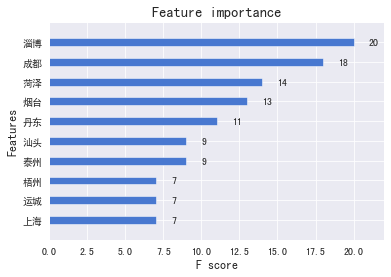

In [21]:
# UserInfo_2
x_1 = df_1.iloc[:, :-1]
y_1 = df_1.iloc[:, -1]
model_1 = XGBClassifier()
model_1.fit(x_1, y_1)
plot_importance(model_1, max_num_features=10, height=0.4)

In [22]:
# 除了淄博、成都、菏泽、烟台外其他的城市在UserInfo_2这个特征下都为0
data['is_zibo_UserInfo_2'] = data['UserInfo_2'].map(lambda x: 1 if x == '淄博' else 0)
data['is_chengdu_UserInfo_2'] = data['UserInfo_2'].map(lambda x: 1 if x == '成都' else 0)
data['is_heze_UserInfo_2'] = data['UserInfo_2'].map(lambda x: 1 if x == '菏泽' else 0)
data['is_yantai_UserInfo_2'] = data['UserInfo_2'].map(lambda x: 1 if x == '烟台' else 0)

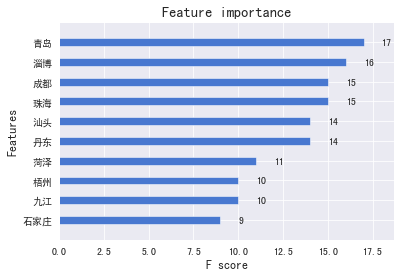

In [37]:
x_2 = df_2.iloc[:,:-1]
y_2 = df_2.iloc[:,-1]
model_2 = XGBClassifier()
model_2.fit(x_2, y_2)
plot_importance(model_2, max_num_features=10, height=0.4)

In [23]:
# 对UserInfo_4进行二值化
data['is_qingdao_UserInfo_4'] = data['UserInfo_4'].map(lambda x: 1 if x == '青岛' else 0)
data['is_zibo_UserInfo_4'] = data['UserInfo_4'].map(lambda x: 1 if x == '淄博' else 0)
data['is_chengdu_UserInfo_4'] = data['UserInfo_4'].map(lambda x: 1 if x == '成都' else 0)
data['is_zhuhai_UserInfo_4'] = data['UserInfo_4'].map(lambda x: 1 if x == '珠海' else 0)

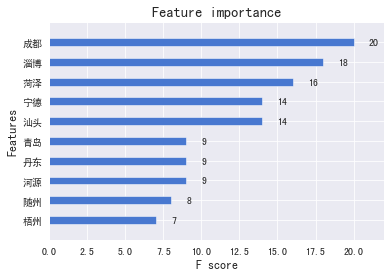

In [39]:
x_3 = df_3.iloc[:,:-1]
y_3 = df_3.iloc[:,-1]
model_3 = XGBClassifier()
model_3.fit(x_3, y_3)
plot_importance(model_3, max_num_features=10, height=0.4)

In [24]:
# 对UserInfo_8进行二值化处理
data['is_chengdu_UserInfo_8'] = data['UserInfo_8'].map(lambda x: 1 if x == '成都' else 0)
data['is_zibo_UserInfo_8'] = data['UserInfo_8'].map(lambda x: 1 if x == '淄博' else 0)
data['is_heze_UserInfo_8'] = data['UserInfo_8'].map(lambda x: 1 if x == '菏泽' else 0)
data['is_ningde_UserInfo_8'] = data['UserInfo_8'].map(lambda x: 1 if x == '宁德' else 0)

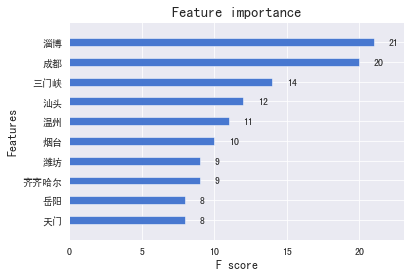

In [47]:
x_4 = df_4.iloc[:,:-1]
y_4 = df_4.iloc[:,-1]
model_4 = XGBClassifier()
model_4.fit(x_4,y_4)
plot_importance(model_4, max_num_features=10, height=0.4)

In [25]:
# 对UserInfo_20进行二值化处理
data['is_zibo_UserInfo_20'] = data['UserInfo_20'].map(lambda x: 1 if x == '淄博' else 0)
data['is_chengdu_UserInfo_20'] = data['UserInfo_20'].map(lambda x: 1 if x == '成都' else 0)
data['is_sanmenxia_UserInfo_20'] = data['UserInfo_20'].map(lambda x: 1 if x == '三门峡' else 0)
data['is_shantou_UserInfo_20'] = data['UserInfo_20'].map(lambda x: 1 if x == '汕头' else 0)

**接着用xgboost来处理相对比较复杂的两个特征：UserInfo_23,WeblogInfo_20**

In [26]:
# 利用xbgoost来处理UserInfo_23和WeblogInfo_20

df_5 = pd.concat([pd.get_dummies(data['UserInfo_23']), data['target']], axis=1)
df_6 = pd.concat([pd.get_dummies(data['WeblogInfo_20']), data['target']], axis=1)

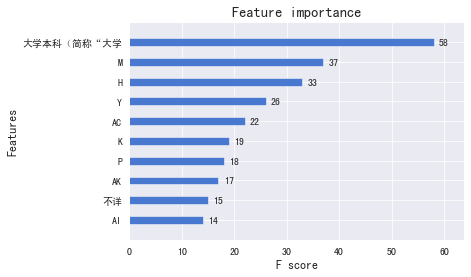

In [62]:
x_5 = df_5.iloc[:,:-1]
y_5 = df_5.iloc[:,-1]
model_5 = XGBClassifier()
model_5.fit(x_5,y_5)
plot_importance(model_5, max_num_features=10, height=0.4)

In [27]:
data['is_undergraduate_UserInfo_23'] = data['UserInfo_23'].map(lambda x: 1 if x == '大学本科（简称“大学' else 0)
data['is_M_UserInfo_23'] = data['UserInfo_23'].map(lambda x:1 if x == 'M' else 0)
data['is_H_UserInfo_23'] = data['UserInfo_23'].map(lambda x:1 if x == 'H' else 0)
data['is_Y_UserInfo_23'] = data['UserInfo_23'].map(lambda x:1 if x == 'Y' else 0)

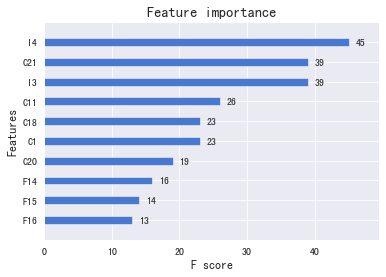

In [65]:
x_6 = df_6.iloc[:,:-1]
y_6 = df_6.iloc[:,-1]
model_6 = XGBClassifier()
model_6.fit(x_6,y_6)
plot_importance(model_6, max_num_features=10, height=0.4)

In [28]:
data['is_I4_WeblogInfo_20'] = data['WeblogInfo_20'].map(lambda x:1 if x == 'I4' else 0)
data['is_C21_WeblogInfo_20'] = data['WeblogInfo_20'].map(lambda x:1 if x == 'C21' else 0)
data['is_I3_WeblogInfo_20'] = data['WeblogInfo_20'].map(lambda x:1 if x == 'I3' else 0)
data['is_C11_WeblogInfo_20'] = data['WeblogInfo_20'].map(lambda x:1 if x == 'C11' else 0)

到此，我将比较复杂，类别较多的变量都进行了按重要性排序的二值化，接下来将这些已经二值化了的object数据进行删除。

In [29]:
obj_list_new = data.select_dtypes(['object'])
obj_list_new.columns

Index(['UserInfo_2', 'UserInfo_4', 'UserInfo_7', 'UserInfo_8', 'UserInfo_9',
       'UserInfo_19', 'UserInfo_20', 'UserInfo_22', 'UserInfo_23',
       'UserInfo_24', 'Education_Info2', 'Education_Info3', 'Education_Info4',
       'Education_Info6', 'Education_Info7', 'Education_Info8',
       'WeblogInfo_19', 'WeblogInfo_20', 'WeblogInfo_21'],
      dtype='object')

In [30]:
del_columns = ['UserInfo_2', 'UserInfo_4', 'UserInfo_7', 'UserInfo_8','UserInfo_19', 'UserInfo_20', 'UserInfo_23', 'UserInfo_24','WeblogInfo_20']
data.drop(columns=del_columns, inplace=True, axis=1)

还剩下10个类别型特征，因为value_counts类别相对较少，所以我认为可对其直接进行独热编码

**3、对剩下的10个类别型特征进行独热编码**

In [31]:
dummies_columns = []
for s in list(obj_list_new.columns):
    if s not in del_columns:
        dummies_columns.append(s)

data_1 = pd.get_dummies(data[dummies_columns])

In [32]:
data_new_1 = pd.concat([data,data_1],axis=1)

In [33]:
data_new_1.drop(columns=dummies_columns, inplace=True, axis=1)

In [34]:
# 将id删掉，因为id感觉不是很有关系
data_new_1.drop(['Idx'],inplace=True,axis=1)

In [35]:
# 获得了可用于训练的训练数据集data_new_1
data_new_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29435 entries, 0 to 29999
Columns: 269 entries, UserInfo_1 to WeblogInfo_21_D
dtypes: float64(175), int64(41), uint8(53)
memory usage: 50.2 MB


**baseline**

In [36]:
# 先训练一个baseline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_1 = data_new_1.drop(['target'],axis=1)
y_1 = data_new_1['target']
X_train,X_test,y_train,y_test = train_test_split(X_1,y_1,test_size=0.25, random_state=0)
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train,y_train, eval_metric='auc')
print("baseline在训练集上的精确度为:{}".format(accuracy_score(y_test, xgb_clf.predict(X_test))))

baseline在训练集上的精确度为:0.9279793450197038


In [37]:
print(xgb_clf.score(X_train,y_train))
print(xgb_clf.score(X_test,y_test))

0.9282025729298786
0.9279793450197038


> #### 2. 特征选择
200多个特征里可能有效的特征不会很多。在这里做特征选择相关的工作。 在特征选择这一块请使用```树```模型。 比如sklearn自带的特征选择模块（https://scikit-learn.org/stable/modules/feature_selection.html）， 或者直接使用XGBoost等模型来直接选择。 这些模型训练好之后你可以直接通过```feature_importance_values```属性来获取。

**用XGBoost来选择特征**

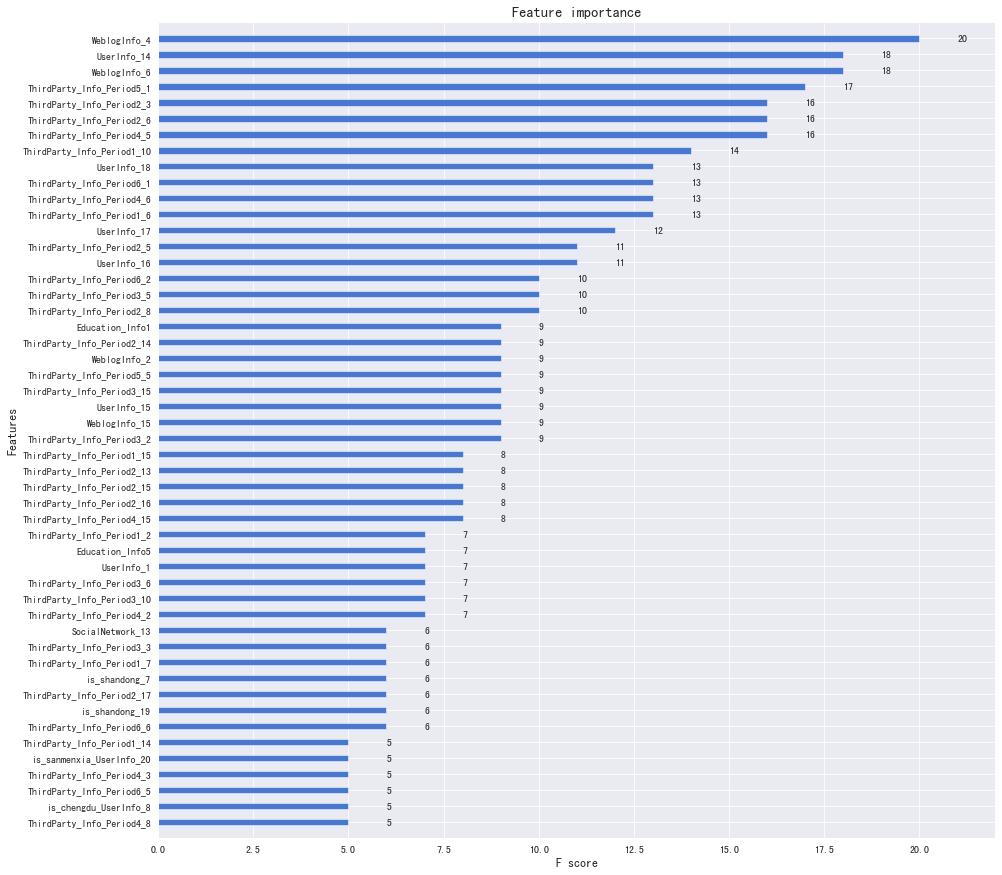

In [53]:
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(xgb_clf, max_num_features=50, height=0.4, ax=ax)

In [71]:
# 借助SelectFromModel来选择xgboost所选择的特征
from sklearn.feature_selection import SelectFromModel
from numpy import sort

thresholds = sorted(xgb_clf.feature_importances_,reverse=True)
for thresh in thresholds:
#     if thresh == 0:
#         break
    # select features using threshold
    selection = SelectFromModel(xgb_clf, threshold=thresh, prefit=True)
    X_train_selected = selection.transform(X_train)
    selection_model = XGBClassifier()
    selection_model.fit(X_train_selected, y_train)
    # eval model
    # 同时需要对测试集进行特征选择
    X_test_selected = selection.transform(X_test)
    accuracy = accuracy_score(y_test, selection_model.predict(X_test_selected))
    print("Thresh=%.8f, n=%d, Accuracy:%.8f" % (thresh, X_train_selected.shape[1], accuracy))

Thresh=0.01969702, n=1, Accuracy:0.92770757
Thresh=0.01594023, n=2, Accuracy:0.92784346
Thresh=0.01512945, n=3, Accuracy:0.92784346
Thresh=0.01503210, n=4, Accuracy:0.92784346
Thresh=0.01373021, n=5, Accuracy:0.92784346
Thresh=0.01343649, n=6, Accuracy:0.92784346
Thresh=0.01302148, n=7, Accuracy:0.92784346
Thresh=0.01256853, n=8, Accuracy:0.92784346
Thresh=0.01245684, n=9, Accuracy:0.92784346
Thresh=0.01194635, n=10, Accuracy:0.92784346
Thresh=0.01183480, n=11, Accuracy:0.92784346
Thresh=0.01180062, n=12, Accuracy:0.92784346
Thresh=0.01163028, n=13, Accuracy:0.92784346
Thresh=0.01148327, n=14, Accuracy:0.92784346
Thresh=0.01141468, n=15, Accuracy:0.92770757
Thresh=0.01117466, n=16, Accuracy:0.92770757
Thresh=0.01112099, n=17, Accuracy:0.92770757
Thresh=0.01091346, n=18, Accuracy:0.92770757
Thresh=0.01080344, n=19, Accuracy:0.92811523
Thresh=0.01036582, n=20, Accuracy:0.92784346
Thresh=0.01032043, n=21, Accuracy:0.92811523
Thresh=0.01028707, n=22, Accuracy:0.92784346
Thresh=0.01025099, 

Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy:0.92797935
Thresh=0.00000000, n=268, Accuracy

KeyboardInterrupt: 

In [40]:
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from numpy import sort


cv = StratifiedKFold(n_splits=3, shuffle=True)

# 定义一个评估函数
def estimate(estimator, X, y, name='estimator'):
    auc = cross_val_score(estimator, X, y, scoring='roc_auc', cv=cv).mean()
    accuracy = cross_val_score(estimator, X, y, scoring='accuracy', cv=cv).mean()
    recall = cross_val_score(estimator, X, y, scoring='recall', cv=cv).mean()
    print("{}: auc:{:f}, recall:{:f}, accuracy:{:f}".format(name, auc, recall, accuracy))

In [41]:
# 利用XGBoost作特征选择
select = SelectFromModel(xgb_clf, threshold=0.00680531, prefit=True)
X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)
X_train_selected = StandardScaler().fit_transform(X_train_selected)
X_test_selected = StandardScaler().fit_transform(X_test_selected)

In [44]:
# 训练模型并做评估
estimate(XGBClassifier(), X_train_selected, y_train, 'XGBClassifier')
estimate(RidgeClassifier(), X_train_selected, y_train, 'RidgeClassifier')
estimate(LogisticRegression(), X_train_selected, y_train, 'LogisticRegression')
estimate(AdaBoostClassifier(), X_train_selected, y_train, 'AdaBoostClassifier')
estimate(RandomForestClassifier(), X_train_selected, y_train, 'RandomForestClassifier')

XGBClassifier: auc:0.730445, recall:0.003129, accuracy:0.927795
RidgeClassifier: auc:0.707909, recall:0.000000, accuracy:0.927387
LogisticRegression: auc:0.709732, recall:0.013769, accuracy:0.927161
AdaBoostClassifier: auc:0.713246, recall:0.024409, accuracy:0.926436
RandomForestClassifier: auc:0.616086, recall:0.005007, accuracy:0.926572


In [46]:
from sklearn.ensemble import VotingClassifier

estimators = []
estimators.append(('LogisticRegression', LogisticRegression()))
estimators.append(('XGBClassifier', XGBClassifier()))
estimators.append(('AdaBoostClassifier', AdaBoostClassifier()))

voting = VotingClassifier(estimators=estimators, voting='soft')
estimate(voting, X_train_selected, y_train, 'voting')

voting: auc:0.734317, recall:0.003756, accuracy:0.927387


In [77]:
data_test = pd.read_csv('data/Test/PPD_Master_GBK_2_Test_Set.csv',encoding='gb18030')


In [81]:
data_test.head()

,Idx,UserInfo_1,UserInfo_2,UserInfo_3,UserInfo_4,WeblogInfo_1,WeblogInfo_2,WeblogInfo_3,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,WeblogInfo_8,WeblogInfo_9,WeblogInfo_10,WeblogInfo_11,WeblogInfo_12,WeblogInfo_13,WeblogInfo_14,WeblogInfo_15,WeblogInfo_16,WeblogInfo_17,WeblogInfo_18,UserInfo_5,UserInfo_6,UserInfo_7,UserInfo_8,UserInfo_9,UserInfo_10,UserInfo_11,UserInfo_12,UserInfo_13,UserInfo_14,UserInfo_15,UserInfo_16,UserInfo_17,UserInfo_18,UserInfo_19,UserInfo_20,UserInfo_21,UserInfo_22,UserInfo_23,UserInfo_24,Education_Info1,Education_Info2,Education_Info3,Education_Info4,Education_Info5,Education_Info6,Education_Info7,Education_Info8,WeblogInfo_19,WeblogInfo_20,WeblogInfo_21,WeblogInfo_23,WeblogInfo_24,WeblogInfo_25,WeblogInfo_26,WeblogInfo_27,WeblogInfo_28,WeblogInfo_29,WeblogInfo_30,WeblogInfo_31,WeblogInfo_32,WeblogInfo_33,WeblogInfo_34,WeblogInfo_35,WeblogInfo_36,WeblogInfo_37,WeblogInfo_38,WeblogInfo_39,WeblogInfo_40,WeblogInfo_41,WeblogInfo_42,WeblogInfo_43,WeblogInfo_44,WeblogInfo_45,WeblogInfo_46,WeblogInfo_47,WeblogInfo_48,WeblogInfo_49,WeblogInfo_50,WeblogInfo_51,WeblogInfo_52,WeblogInfo_53,WeblogInfo_54,WeblogInfo_55,WeblogInfo_56,WeblogInfo_57,WeblogInfo_58,ThirdParty_Info_Period1_1,ThirdParty_Info_Period1_2,ThirdParty_Info_Period1_3,ThirdParty_Info_Period1_4,ThirdParty_Info_Period1_5,ThirdParty_Info_Period1_6,ThirdParty_Info_Period1_7,ThirdParty_Info_Period1_8,ThirdParty_Info_Period1_9,ThirdParty_Info_Period1_10,ThirdParty_Info_Period1_11,ThirdParty_Info_Period1_12,ThirdParty_Info_Period1_13,ThirdParty_Info_Period1_14,ThirdParty_Info_Period1_15,ThirdParty_Info_Period1_16,ThirdParty_Info_Period1_17,ThirdParty_Info_Period2_1,ThirdParty_Info_Period2_2,ThirdParty_Info_Period2_3,ThirdParty_Info_Period2_4,ThirdParty_Info_Period2_5,ThirdParty_Info_Period2_6,ThirdParty_Info_Period2_7,ThirdParty_Info_Period2_8,ThirdParty_Info_Period2_9,ThirdParty_Info_Period2_10,ThirdParty_Info_Period2_11,ThirdParty_Info_Period2_12,ThirdParty_Info_Period2_13,ThirdParty_Info_Period2_14,ThirdParty_Info_Period2_15,ThirdParty_Info_Period2_16,ThirdParty_Info_Period2_17,ThirdParty_Info_Period3_1,ThirdParty_Info_Period3_2,ThirdParty_Info_Period3_3,ThirdParty_Info_Period3_4,ThirdParty_Info_Period3_5,ThirdParty_Info_Period3_6,ThirdParty_Info_Period3_7,ThirdParty_Info_Period3_8,ThirdParty_Info_Period3_9,ThirdParty_Info_Period3_10,ThirdParty_Info_Period3_11,ThirdParty_Info_Period3_12,ThirdParty_Info_Period3_13,ThirdParty_Info_Period3_14,ThirdParty_Info_Period3_15,ThirdParty_Info_Period3_16,ThirdParty_Info_Period3_17,ThirdParty_Info_Period4_1,ThirdParty_Info_Period4_2,ThirdParty_Info_Period4_3,ThirdParty_Info_Period4_4,ThirdParty_Info_Period4_5,ThirdParty_Info_Period4_6,ThirdParty_Info_Period4_7,ThirdParty_Info_Period4_8,ThirdParty_Info_Period4_9,ThirdParty_Info_Period4_10,ThirdParty_Info_Period4_11,ThirdParty_Info_Period4_12,ThirdParty_Info_Period4_13,ThirdParty_Info_Period4_14,ThirdParty_Info_Period4_15,ThirdParty_Info_Period4_16,ThirdParty_Info_Period4_17,ThirdParty_Info_Period5_1,ThirdParty_Info_Period5_2,ThirdParty_Info_Period5_3,ThirdParty_Info_Period5_4,ThirdParty_Info_Period5_5,ThirdParty_Info_Period5_6,ThirdParty_Info_Period5_7,ThirdParty_Info_Period5_8,ThirdParty_Info_Period5_9,ThirdParty_Info_Period5_10,ThirdParty_Info_Period5_11,ThirdParty_Info_Period5_12,ThirdParty_Info_Period5_13,ThirdParty_Info_Period5_14,ThirdParty_Info_Period5_15,ThirdParty_Info_Period5_16,ThirdParty_Info_Period5_17,ThirdParty_Info_Period6_1,ThirdParty_Info_Period6_2,ThirdParty_Info_Period6_3,ThirdParty_Info_Period6_4,ThirdParty_Info_Period6_5,ThirdParty_Info_Period6_6,ThirdParty_Info_Period6_7,ThirdParty_Info_Period6_8,ThirdParty_Info_Period6_9,ThirdParty_Info_Period6_10,ThirdParty_Info_Period6_11,ThirdParty_Info_Period6_12,ThirdParty_Info_Period6_13,ThirdParty_Info_Period6_14,ThirdParty_Info_Period6_15,ThirdParty_Info_Period6_16,ThirdParty_Info_Period6_17,ThirdParty_Info_Period7_1,ThirdParty_Info_Period7_2,ThirdParty_Info_Period7_3,ThirdParty_Info_Perio